<a href="https://colab.research.google.com/github/Aayushktyagi/DeepLearning_Resources/blob/master/RNA_seq_DNN_hyperparamter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

In [ ]:
import time
import numpy as np
import pandas as pd 
import tensorflow as tf 
import sklearn 
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorboard.plugins.hparams import api as hp

In [ ]:
filepath = '/content/drive/My Drive/ColabNotebooks/Cancer/RNA_seq_labeled_primary.csv'
raw_data = pd.read_csv(filepath, sep = ',')
raw_data.head()
dataframe = raw_data.copy()
# data = data.drop(data.index[0])
dataframe.head()

,sampleID,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,ATRX,PMM2,LOC100272146,ASS1,NCBP1,ZNF709,ZNF708,RBM14,NCBP2,DISC1,CAMK1,RPL37,SPR,ZNF700,ZNF707,CAMK4,ZNF704,LOC339240,GOLGA6B,RNF115,RNF112,ZC3H14,SPN,HMGCLL1,NACAP1,...,ACAP2,ACAP3,LUZP4,OR10J5,LUZP6,C1orf198,CFL2,CFL1,OR10J3,C8orf83,C1orf192,PLAA,C8orf80,C8orf86,C8orf85,C8orf84,NFIC,NFIB,H1FOO,NFIX,PLEKHG6,PLEKHG7,PLEKHG4,PLEKHG5,SLC7A14,SELE,SLC7A10,PLA2G2C,METTL11A,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,label
0,TCGA-CA-5256-01,10.1616,3.7172,0.0000,10.4857,10.5157,11.1805,11.3755,2.7680,0.0000,2.2321,10.4496,0.0000,8.8640,0.0000,9.3775,11.2484,6.1007,13.4524,10.7642,6.7441,7.7266,9.9810,11.9751,4.8262,8.6103,14.4843,10.9548,8.4412,6.9918,3.0698,6.5216,0.0,0.0000,8.1044,1.3702,9.5912,5.5207,2.0600,7.5548,...,9.8673,8.4951,0.0,0.0,11.8241,9.1441,7.6565,14.5395,0.0,10.4282,1.8646,9.9139,2.7680,0.0000,1.0403,6.6637,7.5262,8.4565,0.0,9.3462,10.5922,3.7740,8.6320,8.5671,0.0000,4.1624,1.3702,0.0,10.2633,0.0,0.0000,4.0747,0.6119,8.0334,9.4792,5.7645,12.5517,3.9322,10.8937,Stage IIA
1,TCGA-AZ-6599-01,11.1212,2.3437,0.0000,11.6878,10.3830,9.9166,11.9240,2.4817,0.0000,3.4169,9.7643,0.0000,8.8247,0.0000,10.0715,10.5191,5.5343,12.1302,10.6109,6.2459,6.7480,10.4944,10.8831,6.5712,6.9435,13.9471,10.3406,8.1277,7.2890,4.9331,7.9725,0.0,0.0000,8.0904,2.4817,10.4349,5.6704,0.5941,7.4532,...,9.7920,9.5212,0.0,0.0,11.1356,10.2243,6.9869,14.2384,0.0,10.2780,4.0699,9.2377,1.3383,0.5941,1.3383,10.4418,8.9842,9.3824,0.0,11.3403,9.8757,5.8970,10.6252,8.7413,0.0000,2.7234,0.0000,0.0,8.9257,0.0,0.5941,1.8268,1.3383,8.3262,8.9279,4.8842,11.6017,4.1549,10.5855,Stage I
2,TCGA-AA-3655-01,11.0245,2.0858,0.5495,11.5062,9.9334,9.6560,11.6354,3.7064,0.9465,3.3607,9.4322,0.5495,8.6209,0.9465,11.0433,10.9326,5.9695,12.5693,10.6616,6.0423,6.8519,10.6599,10.5108,7.4840,7.7608,13.1868,10.1857,8.1032,6.9740,2.3709,7.4690,0.0,0.5495,7.9735,2.4947,10.1151,6.8577,1.7303,6.9253,...,10.2136,8.9868,0.0,0.0,12.3580,10.5249,7.3346,14.7722,0.0,9.3289,3.4853,9.7248,1.9190,0.0000,1.5132,5.1793,9.0101,9.6241,0.0,11.0373,9.6741,2.9917,9.5785,9.7169,0.5495,5.7998,0.0000,0.0,9.2596,0.0,0.0000,3.9851,0.5495,8.9149,10.6716,7.0262,12.4103,6.0321,10.3551,Stage II
3,TCGA-A6-6137-01,11.0576,6.0759,0.0000,11.7053,10.2443,10.2250,11.3220,2.8994,0.0000,4.0206,9.1701,0.0000,8.7443,0.5474,10.7429,10.8209,5.9307,12.7200,10.4519,6.0759,7.1520,10.5990,11.5216,6.2953,7.7983,13.1937,10.1062,8.2577,8.2023,4.1387,8.4432,0.0,0.9434,8.2984,3.5941,10.2082,8.0598,2.0809,6.9834,...,10.4387,9.2880,0.0,0.0,11.7345,9.7900,7.2861,14.5882,0.0,9.6269,4.2124,9.5920,4.2825,0.0000,2.2303,4.6169,9.0023,9.7930,0.0,11.4779,10.8237,4.1004,10.4159,8.7035,0.0000,5.4719,0.0000,0.0,9.0675,0.0,4.2124,3.7507,1.7258,8.4940,10.5038,6.9352,11.2349,6.3616,10.2726,Stage IIIB
4,TCGA-CK-4952-01,10.5660,1.9506,0.0000,11.8684,9.8537,9.9356,11.4306,2.6602,0.4950,4.6048,9.3126,0.0000,9.1254,0.0000,9.8556,10.9294,5.0941,12.0369,11.0042,4.5301,5.7496,11.0857,10.5637,6.4625,6.5073,13.5306,9.4557,7.8924,8.4951,1.1557,7.5645,0.0,0.0000,8.1717,2.3486,10.4859,5.0049,1.7891,7.9097,...,9.5390,9.9513,0.0,0.0,11.3376,10.5269,7.6075,14.3301,0.0,9.3664,3.5912,9.8652,1.3991,0.0000,0.4950,10.8802,8.4951,9.4498,0.0,10.7055,9.9930,3.4362,9.4035,8.6309,0.0000,2.8359,0.0000,0.0,9.4047,0.0,0.0000,2.8359,0.0000,9.4633,10.4412,6.7306,10.5621,3.6394,9.9296,Stage IIIC


In [ ]:
dataframe['label'] = dataframe['label'].map({'Stage I':1, 'Stage II':2, 'Stage III':3,
                                                                  'Stage IV':4, 'Stage IA':1,'Stage IIA':2,
                                                                  'Stage IIB':2, 'Stage IIC':2, 'Stage IIIA':3,
                                                                  'Stage IIIB':3,'Stage IIIC':3, 'Stage IVA':4,'Stage IVB':4,'[Discrepancy]':0 }
                                                                 )

dataframe['label'].value_counts()

2.0    110
3.0     80
1.0     45
4.0     39
0.0      3
Name: label, dtype: int64

In [ ]:
# drop genes where all values are zero
dataframe = dataframe.loc[:, (dataframe != 0).any()]
dataframe.shape

(286, 20037)

In [ ]:
# check the rows/columns there sum is zero
df_check = dataframe.loc[(dataframe.sum(axis=1) != 0), (dataframe.sum(axis=0) != 0)]
df_check.shape

(286, 20037)

In [ ]:
# drop rows with NAN
dataframe = dataframe[dataframe['label'].notna()]
# drop label where 0
dataframe = dataframe[dataframe['label'] != 0]

In [ ]:
cat_label = dataframe.pop('label')
# drop gene id
dataframe = dataframe.drop(['sampleID'],axis = 1)

In [ ]:
# Dictionary for key value pair of labels 
num_classes = np.unique(cat_label)
le = preprocessing.LabelEncoder()
le.fit(cat_label)
print(list(le.classes_))
label = le.transform(cat_label)
# print("label:{}".format(label))

[1.0, 2.0, 3.0, 4.0]


In [ ]:
print(dataframe.shape)

(274, 20035)


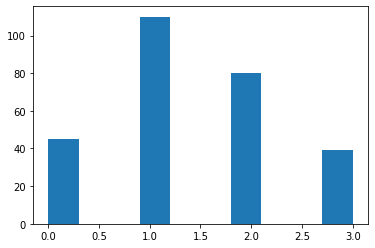

In [ ]:
# data visualization 
plt.hist(label)
plt.show()

In [ ]:
def data_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
# Data Visualization 
def dim_reduction(dataframe):
    pca = PCA(n_components = 50)
    pca_result_50 = pca.fit_transform(dataframe)
    RS = 123
    start_time = time.time()
    data_pca_tsne = TSNE(random_state=RS).fit_transform(pca_result_50)
    data_scatter(data_pca_tsne , label)
    print("Time taken:{}".format(time.time() - start_time))
    return pca_result_50

Time taken:2.0522775650024414


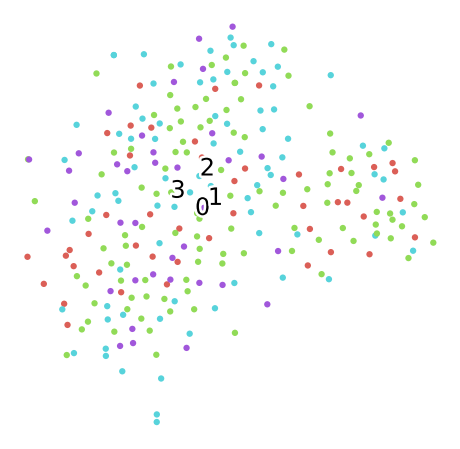

In [ ]:
# Data visualization for un normalized data
data_pca = dim_reduction(dataframe)

In [ ]:
data_des = dataframe.describe()
data_des_transpose = data_des.T['std']
zero_columns = np.where(data_des_transpose.where(data_des_transpose ==0).notnull().tolist())
#drop columns based on idexes
dataframe = dataframe.drop(dataframe.columns[zero_columns],axis=1)
dataframe.shape

(274, 20025)

In [ ]:
# Data normalization 
# # Sklearn minmax scaler 

def normal_dataframe(dataframe , norm_type  , normalize = False):
    if normalize == True:
        if norm_type =='min_max':
            min_max_scaler = preprocessing.MinMaxScaler()
            dataframe_scaled = min_max_scaler.fit_transform(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'Stand_scaler':
            scaler = preprocessing.StandardScaler()
            dataframe_scaled = scaler.fit_transform(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'zscore':
            # data_stats = dataframe.describe()
            # print(data_stats)
            # dataframe_scaled = (dataframe - data_stats['mean'])/ dataframe['std']
            dataframe_scaled = stats.zscore(dataframe)
            return dataframe_scaled
        
        elif norm_type == 'MaxAbsScaler':
            max_abs_scaler = preprocessing.MaxAbsScaler()
            dataframe_scaled = max_abs_scaler.fit_transform(dataframe)
            return dataframe_scaled
            
        elif norm_type == 'log_magnitude':
            dataframe_scaled = dataframe.apply(lambda x : np.log(x+1)) 
            return dataframe_scaled.to_numpy()
        
        elif norm_type == 'log_normalize':
            dataframe_scaled = dataframe.apply(lambda x : np.log(x+1))
            nlise = preprocessing.Normalizer()
            dataframe_normalized = nlise.fit_transform(dataframe_scaled)
            return dataframe_normalized
    else:
        return dataframe.to_numpy()
    
dataframe_scaled = normal_dataframe(dataframe ,'log_normalize', True)
print(dataframe_scaled.shape)

(274, 20025)


Time taken:1.8459928035736084


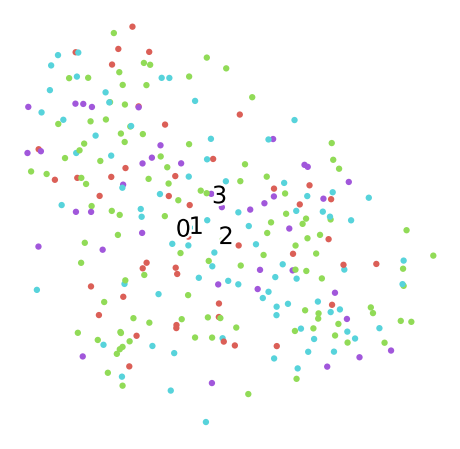

In [ ]:
# Data visualiazation after normalization 
data_pca = dim_reduction(dataframe_scaled)

In [ ]:
#Test train Split
# dataframe = dataframe.drop(['gene_id'],axis = 1)
train, test , Y_train , Y_test = train_test_split(dataframe_scaled, label ,test_size = 0.1)
train , val , Y_train , Y_val = train_test_split(train ,Y_train , test_size = 0.1)
print("trainig data:{}".format(len(train)))
print("Validation data:{}".format(len(val)))
print("Testing data:{}".format(len(test)))
# print("Data Sample:{}".format(train[0]))

trainig data:221
Validation data:25
Testing data:28


In [ ]:
def label_encoder(label):
  # encode class values as integers
  encoder = LabelEncoder()
  encoder.fit(label)
  encoded_Y = encoder.transform(label)
  # convert integers to dummy variables (i.e. one hot encoded)
  dummy_y = np_utils.to_categorical(encoded_Y)
  return dummy_y

In [ ]:
# creating label one hot encoding
train_label_oh = label_encoder(Y_train)
test_label_oh = label_encoder(Y_test)
val_label_oh = label_encoder(Y_val)

In [ ]:
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_LEARNING_RATE =  hp.HParam('learning_rate',hp.Discrete([0.001,0.01,0.1]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.75))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[ HP_LEARNING_RATE,HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
#Base model 
def build_model_dnn(hparams):
  model = tf.keras.Sequential([
      #layer1 - input layer
      layers.Dense(10000 , input_shape= (20025,) , name = 'Input'),
      # adding batchnormalization
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dropout(hparams[HP_DROPOUT]),
      # layers 2 hidden layer
      layers.Dense(1000, name = "Hidden_Layer_2"),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dropout(0.5),
      layers.Dense(1000,  name = 'Hidden_layer_3'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dropout(0.5),
      layers.Dense(100 , name = 'Hidden_layer_4'),
      layers.BatchNormalization(),
      layers.Activation('relu'),
      layers.Dense(4 , activation = 'softmax' , name = "Output_layer")
  ])
  optimizer_name = hparams[HP_OPTIMIZER]
  learning_rate = hparams[HP_LEARNING_RATE]
  if optimizer_name == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer_name == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

  model.compile(loss = 'categorical_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])
  callbacks = [
    EarlyStopping(patience=10, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1,monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(logdir),
    # hp.KerasCallback(logdir, hparams)
    ]

    #Model training 
  history = model.fit(
            train, train_label_oh,
            validation_data=(val, val_label_oh),
            epochs = 100,
            batch_size = 32,
            callbacks=callbacks,
            verbose=1)
  
  _, accuracy = model.evaluate(test, test_label_oh)
  del model

  return accuracy
# model = build_model_dnn(hparams)
# model.summary()

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = build_model_dnn(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0

for lr in HP_LEARNING_RATE.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_LEARNING_RATE: lr,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
def predict(test):
    predictions = model.predict(test)
    predict_index = predictions.argmax(axis=1)
    # print(predict_index,np.shape(predict_index))
    test_index = test_label_oh.argmax(axis=1)
    # print(test_index,np.shape(test_index))
    results = confusion_matrix(test_index,predict_index)


    #Classification accuracy
    accuracy = accuracy_score(test_index,predict_index)
    print("Classification accuracy:{}".format(accuracy))
    print()
    print(accuracy)

    #Classification report 
    classify_report = classification_report(test_index,predict_index)
    print("Classification report")
    print(classify_report)

# predict(test)